# Débruitage d'image : 
    Notebook de préparation de la donnée : bruitage et sauvegarde.

Absctract :
    The images that are captured in the real world come with noises. These noises can appear due to many reasons such as electric signal instabilities, malfunctioning of camera sensors, poor lighting conditions, errors in data transmission over long distances, etc. This can degrade the captured image's quality and can cause loss of information as the original pixel values are replaced by random values due to noise. So, there is a need to remove these noises from images when it comes to low-level vision tasks and image processing. The process of removing such noises from images is known as Image Denoising.

## Step 1 - Imports

In [1]:
# Import des bibliothèques
import numpy as np
from typing import List, Tuple, Dict, Union
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

import os
## Remettre la ligne pour utiliser le backend Jax et tester si ca marche de nouveau
os.environ["KERAS_BACKEND"] = "jax"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Suppression des avertissements de TensorFlow
from keras import layers
from keras.models import Model
from huggingface_hub import from_pretrained_keras
import cv2
from PIL import Image
import glob
from tqdm.notebook import tqdm
import random
from sklearn.model_selection import train_test_split
import time
from skimage.metrics import structural_similarity
import shutil
from pathlib import Path
from keras.applications import VGG19
from keras.models import Model
from keras import backend as K
import tensorflow as tf


print("Versions des bibliothèques:")
print(f"TensorFlow: {tf.__version__}")
print(f"Keras: {keras.__version__}")


2025-04-15 08:28:45.793830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744698525.879370     647 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744698525.900417     647 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744698526.064955     647 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744698526.064991     647 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744698526.064994     647 computation_placer.cc:177] computation placer alr

Versions des bibliothèques:
TensorFlow: 2.19.0
Keras: 3.9.0


## EDA

In [30]:
## Est conduite dans la cellule suivante

## Step 2 - Paramètres et copie sur WSL (du dataset raw)

In [31]:
# Configuration des paramètres globaux

NOISE_LEVEL = 0.3     # Niveau de bruit global (0.05 = très faible, 0.1 = faible, 0.2 = moyen, 0.5 = fort, 1-2 : très fort)
NOISE_TYPE = "gaussian"  # Type de bruit: "gaussian", "salt_pepper", ou "speckle"
IMAGE_SIZE = 256      # Taille des images
BATCH_SIZE = 16       # Taille du batch
SEED = 42            # Seed pour la reproducibilité

np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Définir les chemins d'accès
WINDOWS_DIR = '/mnt/c/Users/NyveK/Downloads/Datasets/Datasets/livrable2/Dataset'
TARGET_WSL_L1_DIR = '/home/kevin/datasets/livrable1/raw/Photo'
TARGET_WSL_DIR = '/home/kevin/datasets/livrable2/raw'
TARGET_PROCESSED_L2_DIR = '/home/kevin/datasets/livrable2/raw'
TARGET_PROCESSED_DIR = '/home/kevin/datasets/livrable2/processed'

# Vérifier si le chemin Windows existe
windows_exists = os.path.exists(WINDOWS_DIR)
print(f"Le chemin Windows existe: {windows_exists}")

# Créer les dossiers de destination s'ils n'existent pas
Path(TARGET_WSL_DIR).mkdir(parents=True, exist_ok=True)
Path(TARGET_PROCESSED_DIR).mkdir(parents=True, exist_ok=True)

# Copier les données uniquement si le chemin source existe
if windows_exists:
    print(f"Copie des données depuis {WINDOWS_DIR} vers {TARGET_WSL_DIR}...")
    try:
        shutil.copytree(WINDOWS_DIR, TARGET_WSL_DIR, dirs_exist_ok=True)
        print("Copie terminée avec succès!")
    except Exception as e:
        print(f"Erreur lors de la copie: {e}")
else:
    print(f"ATTENTION: Le chemin source {WINDOWS_DIR} n'existe pas!")
    print("Veuillez vérifier le chemin et le monter correctement dans WSL.")
    print("Utilisation du chemin WSL directement s'il existe déjà...")

# Utiliser TARGET_WSL_DIR comme chemin de base s'il existe et contient des données
BASE_DIR = TARGET_WSL_DIR if os.path.exists(TARGET_WSL_DIR) and os.listdir(TARGET_WSL_DIR) else None

# Avertir l'utilisateur si aucun chemin valide n'est trouvé
if BASE_DIR is None:
    print("Aucun chemin valide trouvé pour les données. Le code utilisera des données de démonstration.")


print(f"Configuration : NOISE_LEVEL={NOISE_LEVEL}, NOISE_TYPE={NOISE_TYPE}, IMAGE_SIZE={IMAGE_SIZE}x{IMAGE_SIZE}")

# EDA (Exploratory Data Analysis)
# Compter le nombre d'images dans le dossier source
if BASE_DIR:
    image_files = [f for f in os.listdir(BASE_DIR) if f.endswith('.jpg') or f.endswith('.png')]
    num_images = len(image_files)
    print(f"Nombre d'images dans le dossier source : {num_images}")
else:
    print("Aucun dossier source valide trouvé. Aucune image à compter.")


# Print des informations sur les dataset copiés
print(f"Contenu du dossier source : {os.listdir(BASE_DIR) if BASE_DIR else 'Aucun contenu'}")
print(f"Contenu du dossier cible : {os.listdir(TARGET_WSL_DIR) if os.path.exists(TARGET_WSL_DIR) else 'Aucun contenu'}")
print(f"Shape des images source : {[Image.open(os.path.join(BASE_DIR, f)).size for f in os.listdir(BASE_DIR) if f.endswith('.jpg')] if BASE_DIR else 'Aucune image'}") 
print(f"Shape des images cible : {[Image.open(os.path.join(TARGET_WSL_DIR, f)).size for f in os.listdir(TARGET_WSL_DIR) if f.endswith('.jpg')] if os.path.exists(TARGET_WSL_DIR) else 'Aucune image'}")

# Normalisation des images
def normalize_image(image):
    """
    Normalise une image entre 0 et 1.
    """
    return image.astype(np.float32) / 255.0

# Resize les images vers leur nouvelle shape
def resize_image(image, target_size=(IMAGE_SIZE, IMAGE_SIZE)):
    """
    Redimensionne une image à la taille cible.
    """
    return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)


Le chemin Windows existe: False
ATTENTION: Le chemin source /mnt/c/Users/NyveK/Downloads/Datasets/Datasets/livrable2/Dataset n'existe pas!
Veuillez vérifier le chemin et le monter correctement dans WSL.
Utilisation du chemin WSL directement s'il existe déjà...
Configuration : NOISE_LEVEL=0.3, NOISE_TYPE=gaussian, IMAGE_SIZE=256x256
Nombre d'images dans le dossier source : 298
Contenu du dossier source : ['photo_4059.jpg', 'noisy_144.jpg', 'noisy_113.jpg', 'photo_7185.jpg', 'noisy_059.jpg', 'photo_0017.jpg', 'photo_2460.jpg', 'photo_9132.jpg', 'noisy_077.jpg', 'photo_5272.jpg', 'noisy_065.jpg', 'photo_6383.jpg', 'photo_5137.jpg', 'noisy_068.jpg', 'noisy_127.jpg', 'noisy_121.jpg', 'photo_0611.jpg', 'noisy_111.jpg', 'noisy_114.jpg', 'noisy_063.jpg', 'photo_6001.jpg', 'noisy_047.jpg', 'noisy_098.jpg', 'photo_1094.jpg', 'noisy_122.jpg', 'photo_6460.jpg', 'noisy_016.jpg', 'photo_5562.jpg', 'photo_6352.jpg', 'noisy_108.jpg', 'photo_9915.jpg', 'noisy_107.jpg', 'photo_2012.jpg', 'noisy_052.jpg'

On remarque que l'on dispose seulement de 148 images sources pour contruire notre encodeur :
- l'entrainer
- valider sa structure
- tester et valider ses performance


La stratégie ici sera d'incrémenter notre dataset par des photos issues du livrable 1 dans la classe photos et de rendre compte de l'amélioration des résultats ou non.

In [ ]:
## Ajouter des images depuis le dataset du livrable 1

INCREMENT = 150  # Nombre d'images à ajouter (ajout d'un elimite pour réexecution)

def add_images_from_livrable1(source_dir, target_dir, seed, number, image_size=(IMAGE_SIZE, IMAGE_SIZE)):
    """
    Ajoute des images du livrable 1 au dossier cible.
    """
    # Créer le dossier cible s'il n'existe pas
    os.makedirs(target_dir, exist_ok=True)

    # Obtenir la liste des fichiers d'images
    image_files = [f for f in os.listdir(source_dir) if f.endswith('.jpg') or f.endswith('.png')]
    
    # Vérifier si le nombre demandé est supérieur au nombre d'images disponibles
    available_count = len(image_files)
    if number > available_count:
        print(f"Attention: Seulement {available_count} images disponibles dans {source_dir}.")
        print(f"Utilisation de toutes les {available_count} images au lieu de {number}.")
        number = available_count
    
    # Sélectionner un sous-ensemble aléatoire d'images
    random.seed(seed)
    selected_files = random.sample(image_files, number)

    # Copier et redimensionner les images
    for file_name in selected_files:
        img_path = os.path.join(source_dir, file_name)
        img = cv2.imread(img_path)
        img_resized = resize_image(img, target_size=image_size)
        img_normalized = normalize_image(img_resized)
        output_path = os.path.join(target_dir, file_name)
        cv2.imwrite(output_path, img_normalized * 255)  # Sauvegarder l'image normalisée

def limit_images_count(source_dir, target_dir, max_count):
    """
    Limite le nombre d'images dans le dossier cible à max_count.
    """
    max_count+=148  # Ajouter le nombre d'images déjà présentes
    os.makedirs(target_dir, exist_ok=True)
    image_files = [f for f in os.listdir(source_dir) if f.endswith('.jpg') or f.endswith('.png')]
    
    # Si le nombre d'images dépasse max_count, supprimer les images les plus récentes
    if len(image_files) > max_count:
        image_files.sort(key=lambda x: os.path.getmtime(os.path.join(source_dir, x)), reverse=True)
        files_to_remove = image_files[max_count:]
        for file_name in files_to_remove:
            os.remove(os.path.join(source_dir, file_name))


add_images_from_livrable1(TARGET_WSL_L1_DIR, TARGET_PROCESSED_L2_DIR, SEED, INCREMENT, image_size=(IMAGE_SIZE, IMAGE_SIZE))
limit_images_count(TARGET_PROCESSED_DIR, TARGET_PROCESSED_DIR, INCREMENT)

## Step 3 -  Application des pré-traitement nécessaire pré bruitage

In [33]:
# # Fonction pour ajouter du bruit à une image
# def noise_it(data):
#     new_data = data.copy()
#     if NOISE_TYPE == "gaussian":
#         noise = np.random.normal(0, NOISE_LEVEL, data.shape)
#         new_data = np.clip(data + noise, 0, 1)
#     elif NOISE_TYPE == "salt_pepper":
#         s_vs_p = 0.5
#         amount = NOISE_LEVEL
#         out = np.copy(data)
#         # Salt mode
#         num_salt = np.ceil(amount * data.size * s_vs_p)
#         coords = [np.random.randint(0, i - 1, int(num_salt)) for i in data.shape]
#         out[coords] = 1
#         # Pepper mode
#         num_pepper = np.ceil(amount* data.size * (1. - s_vs_p))
#         coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in data.shape]
#         out[coords] = 0
#         new_data = out
#     elif NOISE_TYPE == "speckle":
#         noise = np.random.normal(0, NOISE_LEVEL, data.shape)
#         new_data = np.clip(data + data * noise, 0, 1)
#     else:
#         raise ValueError("Type de bruit non supporté. Choisissez entre 'gaussian', 'salt_pepper' ou 'speckle'.")
#     return new_data



## Step 4 - Ajout du bruit

In [34]:
def add_noise_to_image(image, noise_type="gaussian", noise_level=0.1):
    """
    Ajoute du bruit à une image normalisée (valeurs entre 0 et 1).
    
    Args:
        image (np.ndarray): Image normalisée (H, W, C)
        noise_type (str): Type de bruit : "gaussian", "salt_pepper", ou "speckle"
        noise_level (float): Intensité du bruit (ex: 0.1 = faible, 0.5 = fort)
    
    Returns:
        np.ndarray: Image bruitée, toujours entre 0 et 1
    """
    noisy = image.copy()

    if noise_type == "gaussian":
        noise = np.random.normal(loc=0, scale=noise_level, size=image.shape)
        noisy = noisy + noise

    elif noise_type == "salt_pepper":
        prob = noise_level
        rnd = np.random.rand(*image.shape[:2])
        salt = rnd < prob / 2
        pepper = rnd > 1 - prob / 2

        if image.shape[-1] == 1:
            noisy[salt, 0] = 1.0
            noisy[pepper, 0] = 0.0
        else:
            for c in range(image.shape[-1]):
                noisy[salt, c] = 1.0
                noisy[pepper, c] = 0.0

    elif noise_type == "speckle":
        noise = np.random.randn(*image.shape)
        noisy = noisy + noisy * noise_level * noise

    else:
        raise ValueError(f"Bruit inconnu : {noise_type}")

    return np.clip(noisy, 0.0, 1.0)


def process_and_save_noisy_images(
    input_dir, output_dir, 
    image_size=(256, 256),
    noise_type="salt_pepper", 
    noise_level=0.5
):
    """
    Charge, redimensionne et normalise les images d'un dossier,
    ajoute du bruit et sauvegarde les images "clean" et "noisy" dans deux sous-dossiers.
    """

    # Création des sous-dossiers pour les images clean et noisy
    clean_dir = os.path.join(output_dir, "clean")
    noisy_dir = os.path.join(output_dir, "noisy")
    Path(clean_dir).mkdir(parents=True, exist_ok=True)
    Path(noisy_dir).mkdir(parents=True, exist_ok=True)

    image_paths = sorted([
        f for f in os.listdir(input_dir)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ])
    print(f"{len(image_paths)} images trouvées dans {input_dir}.")

    for filename in tqdm(image_paths, desc="Traitement des images"):
        image_path = os.path.join(input_dir, filename)

        # Chargement, redimensionnement et normalisation
        image = np.array(Image.open(image_path).convert("RGB"))
        image = cv2.resize(image, image_size, interpolation=cv2.INTER_AREA)
        image = normalize_image(image)  # Fonction externe

        # Ajout du bruit
        noisy_image = add_noise_to_image(image, noise_type=noise_type, noise_level=noise_level)  # Fonction externe

        # Conversion en format uint8 pour sauvegarde
        clean_image_uint8 = (image * 255).astype(np.uint8)
        noisy_image_uint8 = (noisy_image * 255).astype(np.uint8)

        # Sauvegarde dans les sous-dossiers respectifs
        Image.fromarray(clean_image_uint8).save(os.path.join(clean_dir, filename))
        Image.fromarray(noisy_image_uint8).save(os.path.join(noisy_dir, filename))

In [35]:

# Ajout de bruit
process_and_save_noisy_images(
    input_dir=TARGET_WSL_DIR,
    output_dir=TARGET_PROCESSED_DIR,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    noise_type=NOISE_TYPE,
    noise_level=NOISE_LEVEL
)


print("Images bruitées sauvegardées dans :", TARGET_PROCESSED_DIR)
print("Exemple de contenu :", os.listdir(TARGET_PROCESSED_DIR)[:5])

298 images trouvées dans /home/kevin/datasets/livrable2/raw.


Traitement des images:   0%|          | 0/298 [00:00<?, ?it/s]

Images bruitées sauvegardées dans : /home/kevin/datasets/livrable2/processed
Exemple de contenu : ['clean', 'noisy']


## Step 5 - Visualisation 👀

/tmp/ipykernel_610/3258303292.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


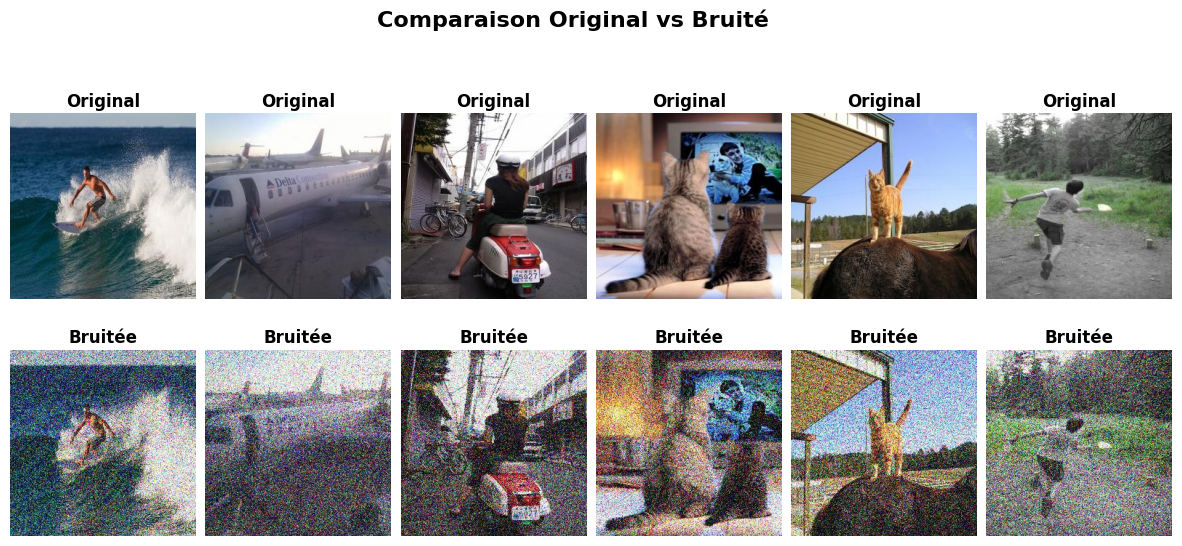

In [36]:
import matplotlib.gridspec as gridspec

def show_comparison_grid(original_dir, noisy_dir, n=5, image_size=(256, 256), titles=True):
    """
    Affiche une grille stylisée de comparaison Original vs Bruité.
    """
    # Obtenir les noms communs d'images
    image_files = sorted([f for f in os.listdir(original_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])[:n]

    fig = plt.figure(figsize=(n * 2.5, 6))  # Largeur ajustée à n, hauteur fixe
    gs = gridspec.GridSpec(2, n, wspace=0.05, hspace=0.05)

    for i, filename in enumerate(image_files):
        # Chargement des deux images
        orig_path = os.path.join(original_dir, filename)
        noisy_path = os.path.join(noisy_dir, filename)

        orig = Image.open(orig_path).resize(image_size)
        noisy = Image.open(noisy_path).resize(image_size)

        # Subplot Original
        ax1 = fig.add_subplot(gs[0, i])
        ax1.imshow(orig)
        ax1.axis('off')
        if titles:
            ax1.set_title("Original", fontsize=12, weight='bold', pad=5)

        # Subplot Bruitée
        ax2 = fig.add_subplot(gs[1, i])
        ax2.imshow(noisy)
        ax2.axis('off')
        if titles:
            ax2.set_title("Bruitée", fontsize=12, weight='bold', pad=5)

        # Style optionnel : bordure légère autour des images
        for ax in [ax1, ax2]:
            for spine in ax.spines.values():
                spine.set_edgecolor('gray')
                spine.set_linewidth(0.5)

    fig.suptitle("Comparaison Original vs Bruité", fontsize=16, weight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

show_comparison_grid(
    original_dir=os.path.join(TARGET_PROCESSED_DIR, "clean"),
    noisy_dir=os.path.join(TARGET_PROCESSED_DIR, "noisy"),
    n=6
)



## Step 6 - Métriques post traitement

Calculating metrics:   0%|          | 0/298 [00:00<?, ?it/s]

Processed 298 images successfully.
Average PSNR: 14.70 dB
Average SSIM: 0.2022


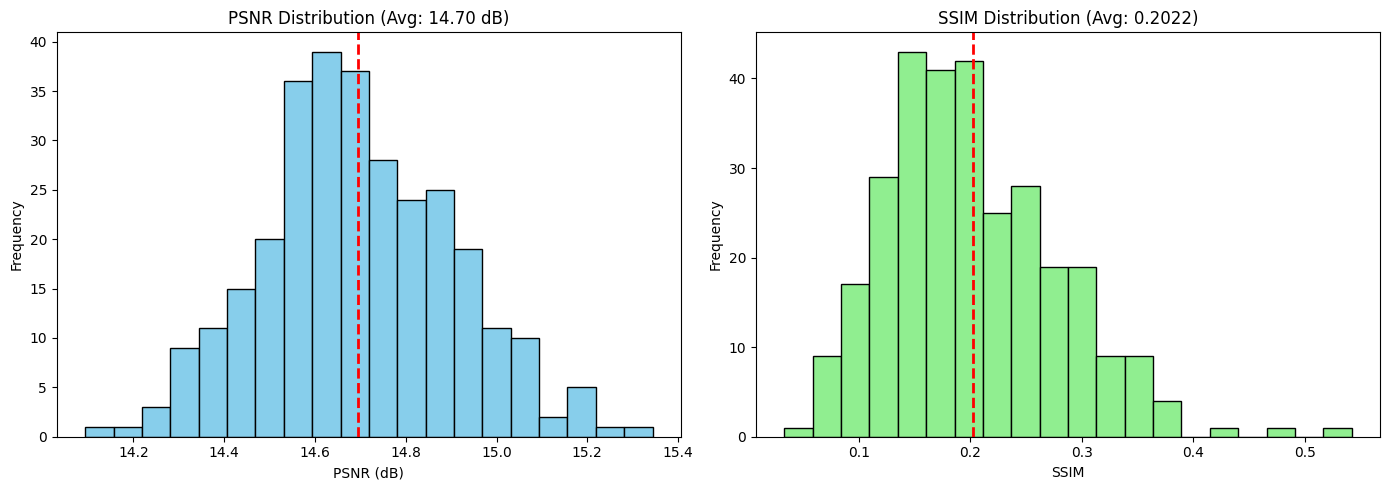

In [47]:
def psnr(original: np.ndarray, noisy: np.ndarray) -> float:
    """
    Calculate Peak Signal-to-Noise Ratio between two images.
    
    Args:
        original: Original image array, normalized to [0,1]
        noisy: Noisy image array, normalized to [0,1]
        
    Returns:
        float: PSNR value in dB (higher is better)
    """
    mse = np.mean((original - noisy) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value


def compute_ssim(original: np.ndarray, noisy: np.ndarray) -> float:
    """
    Calculate Structural Similarity Index between two images.
    
    Args:
        original: Original image array, normalized to [0,1]
        noisy: Noisy image array, normalized to [0,1]
        
    Returns:
        float: SSIM value (higher is better, max is 1.0)
    """
    return structural_similarity(original, noisy, data_range=1.0, channel_axis=2)


def calculate_metrics(
    original_dir: str, 
    noisy_dir: str, 
    n: int = -1, 
    metrics: List[str] = ["psnr", "ssim"],
    verbose: bool = True,
    return_individual: bool = False
) -> Union[Tuple[float, float], Dict[str, Union[List[float], float]]]:
    """
    Calculate image quality metrics between original and noisy image pairs.
    
    Args:
        original_dir: Directory containing original images
        noisy_dir: Directory containing corresponding noisy images
        n: Number of images to process (-1 for all images)
        metrics: List of metrics to calculate (supported: "psnr", "ssim")
        verbose: Whether to show progress bar
        return_individual: If True, returns a dict with individual values and averages
        
    Returns:
        If return_individual=False: Tuple of average metrics (psnr, ssim)
        If return_individual=True: Dict with keys 'psnr', 'ssim', 'psnr_avg', 'ssim_avg', 'filenames'
    """
    # Validate inputs
    if not os.path.exists(original_dir):
        raise FileNotFoundError(f"Original directory does not exist: {original_dir}")
    if not os.path.exists(noisy_dir):
        raise FileNotFoundError(f"Noisy directory does not exist: {noisy_dir}")
        
    # Get common image files in both directories
    orig_files = set([f for f in os.listdir(original_dir) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    noisy_files = set([f for f in os.listdir(noisy_dir) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    common_files = sorted(list(orig_files.intersection(noisy_files)))
    
    if not common_files:
        raise ValueError(f"No matching image files found in both directories")
    
    # Limit number of files if specified
    if n > 0:
        common_files = common_files[:n]
    
    # Initialize metric storage
    psnr_values = []
    ssim_values = []
    processed_files = []
    errors = []

    # Process files with progress bar if requested
    iterator = tqdm(common_files, desc="Calculating metrics") if verbose else common_files

    for filename in iterator:
        try:
            # Load and normalize images
            orig_path = os.path.join(original_dir, filename)
            noisy_path = os.path.join(noisy_dir, filename)

            orig = np.array(Image.open(orig_path).convert("RGB")) / 255.0
            noisy = np.array(Image.open(noisy_path).convert("RGB")) / 255.0
            
            # Skip if images are not the same shape
            if orig.shape != noisy.shape:
                errors.append(f"Image shapes don't match for {filename}: {orig.shape} vs {noisy.shape}")
                continue

            # Calculate metrics
            if "psnr" in metrics:
                psnr_values.append(psnr(orig, noisy))
            if "ssim" in metrics:
                ssim_values.append(compute_ssim(orig, noisy))
                
            processed_files.append(filename)
                
        except Exception as e:
            errors.append(f"Error processing {filename}: {str(e)}")
    
    # Report any errors
    if errors and verbose:
        print(f"Encountered {len(errors)} errors:")
        for err in errors[:5]:  # Show first 5 errors
            print(f"  - {err}")
        if len(errors) > 5:
            print(f"  ... and {len(errors) - 5} more.")
    
    # Calculate averages
    psnr_avg = np.mean(psnr_values) if psnr_values else np.nan
    ssim_avg = np.mean(ssim_values) if ssim_values else np.nan
    
    if verbose:
        print(f"Processed {len(processed_files)} images successfully.")
        print(f"Average PSNR: {psnr_avg:.2f} dB")
        print(f"Average SSIM: {ssim_avg:.4f}")
    
    # Return results based on format requested
    if return_individual:
        return {
            'psnr': psnr_values,
            'ssim': ssim_values,
            'psnr_avg': psnr_avg,
            'ssim_avg': ssim_avg,
            'filenames': processed_files
        }
    else:
        return psnr_avg, ssim_avg


def visualize_metrics(metrics_dict: Dict) -> None:
    """
    Visualize the distribution of metrics.
    
    Args:
        metrics_dict: Dictionary with 'psnr', 'ssim', and 'filenames' keys
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # PSNR histogram
    ax1.hist(metrics_dict['psnr'], bins=20, color='skyblue', edgecolor='black')
    ax1.axvline(metrics_dict['psnr_avg'], color='red', linestyle='--', linewidth=2)
    ax1.set_xlabel('PSNR (dB)')
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'PSNR Distribution (Avg: {metrics_dict["psnr_avg"]:.2f} dB)')
    
    # SSIM histogram
    ax2.hist(metrics_dict['ssim'], bins=20, color='lightgreen', edgecolor='black')
    ax2.axvline(metrics_dict['ssim_avg'], color='red', linestyle='--', linewidth=2)
    ax2.set_xlabel('SSIM')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'SSIM Distribution (Avg: {metrics_dict["ssim_avg"]:.4f})')
    
    plt.tight_layout()
    plt.show()


# Example usage with detailed output
metrics_results = calculate_metrics(
    original_dir=os.path.join(TARGET_PROCESSED_DIR, "clean"),
    noisy_dir=os.path.join(TARGET_PROCESSED_DIR, "noisy"),
    n=-1,  #(use -1 for all)
    return_individual=True,
    verbose=True
)

# Optional: Visualize the distribution of metrics
visualize_metrics(metrics_results)